In [108]:
# imports
import string
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
import matplotlib.cm as cm

import sys
sys.path.append("..")
import utils

from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA

In [36]:
# stolen from notebook9
filename = "glove.6B.50d.txt"

embeddings = {}
with open(filename,'r', encoding='utf-8') as file:
    for line in file:
        elements = line.split();
        word = elements[0];
        vector = np.asarray(elements[1:],"float32")
        embeddings[word] = vector

In [37]:
# functions
def preprocess(text, punctuation=False):
    """
    Parameters:
    text (string): raw text from data

    Returns:
    string: string with no punctuation and
            only contains words in embeddings
    """
    if punctuation:
        text_ = ""
        for char in text:
            if char not in string.punctuation:
                text_ += char
        text = text_
    
    text_ = ""
    for word in text.split():
        if word in embeddings:
             text_ += word.lower() + " "
    return text_

def mean_emb(text):
    """
    Parameters:
    text (string): raw text from data
    
    Returns:
    numpy.ndarray(50,): mean embedding of text
    """
    pre = preprocess(text).split()
    sum_emb = np.zeros(50,)
    for word in pre:
        sum_emb += embeddings[word]
    mean_emb = sum_emb/50
    
    return mean_emb

def glove_accuracy(X_train, X_test, y_train, y_test):
    train_embeddings = np.array([mean_emb(text) for text in X_train])
    test_embeddings = np.array([mean_emb(text) for text in X_test])

    clf = GaussianNB().fit(train_embeddings, y_train)

    predictions = clf.predict(test_embeddings)
    accuracy = accuracy_score(y_test, predictions)

    return accuracy

In [26]:
## Spam data

In [38]:
spam_train, spam_test = utils.load_data('spam')
glove_accuracy(spam_train['texts'], spam_test['texts'], spam_train['labels'], spam_test['labels'])

0.9336322869955157

In [47]:
news_train, news_test = utils.load_data('news')
glove_accuracy(news_train['texts'], news_test['texts'], news_train['labels'], news_test['labels'])

0.84

## PCA

## sms

In [109]:
def pca(X_train):
    vectors = np.zeros((50, len(X_train)))
    for i in range(len(X_train)):
        doc = X_train[i]
        vectors[:,i] = mean_emb(doc)
    
    #pca on feature vectors for selected words
    mean_vector = np.mean(vectors,axis=1)
    data = vectors - mean_vector[:,None]
    #compute the covariance matrix
    S = np.cov(data)
    #obtain eigenvectors and eigenvalues
    eigenValues, eigenVectors = eigh(S)
    #sort according to size of eigenvalues
    sort_idx = np.argsort(eigenValues)[::-1]
    eigenValues = eigenValues[sort_idx]
    eigenVectors = eigenVectors[:, sort_idx]
    return eigenValues, eigenVectors, data

In [115]:
def plot_pca(X_train, y_train, PC_range, num_texts):
    eigenValues, eigenVectors, data = pca(X_train)
    X_proj = eigenVectors[:,PC_range[0]:PC_range[1]].T@data    
    #plot for the selected two principal components
    n_label = len(np.unique(y_train))
    colors = cm.rainbow(np.linspace(0, 1, n_label))
    class_idx = y_train
    if n_label == 2:
        considered_classes = ['not-spam','spam']
    else:
        considered_classes = ['World','sports','Business', 'Sci/Tec']
    cdict = {i: colors[i] for i in range(n_label)}
    label_dict = {i: considered_classes[i] for i in range(n_label)}
    for i in range(n_label):
        indices = np.where(class_idx == i)
        plt.scatter(X_proj[0,indices], X_proj[1,indices],
                 color=cdict[i], label=label_dict[i],s=2)
    plt.legend(loc='best')
    plt.xlabel('Principal Component axis 1');
    plt.ylabel('Principal Component axis 2');
    plt.show()

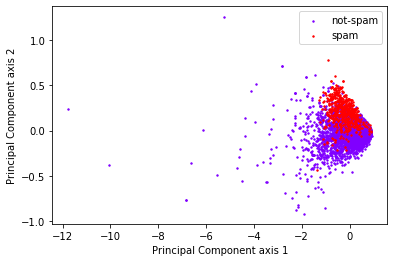

In [116]:
plot_pca(spam_train['texts'], spam_train['labels'], [0,2], None)

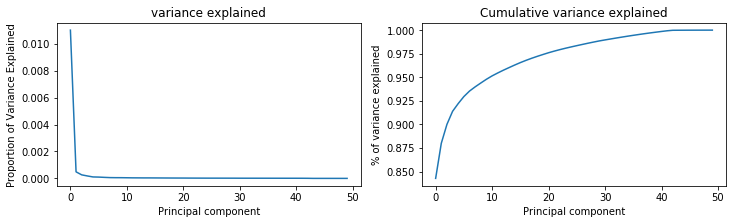

In [280]:
# explained variance
# week5 NB
eigenValues, eigenVectors, _ = pca(spam_train['texts'])

summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(50)
relative_var = np.zeros(50)
for i in range(50):    
    relative_var[i] = eigenValues[i]/np.size(eigenValues)
    cumsum += eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig = plt.figure(figsize=(12,3))
plt.subplot(121)
# this might not be calculated correctly (line 10)
plt.plot(relative_var)
plt.xlabel("Principal component")
plt.ylabel("Proportion of Variance Explained")
plt.title('variance explained');
plt.subplot(122) 
plt.plot(total_var_explained)
plt.xlabel("Principal component")
plt.ylabel("% of variance explained")
plt.title('Cumulative variance explained');

Maybe add a vertical line at x=2

In [248]:
total_var_explained[0:2]

array([0.84271529, 0.87993501])

### News

Currently it just shows the first 5000 articles, we could maybe change it to be 5000 random. np.random.choice()

Or we could just say that the first 5k are representative of the population

In [ ]:
plot_pca(news_train['texts'], news_train['labels'], [0,2], 5000)

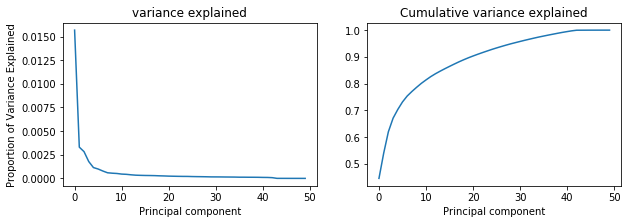

In [282]:
# explained variance
eigenValues, eigenVectors, _ = pca(news_train['texts'])

summ = eigenValues.sum()
cumsum = 0
total_var_explained = np.zeros(50)
relative_var = np.zeros(50)
for i in range(50):    
    relative_var[i] = eigenValues[i]/np.size(eigenValues)
    cumsum += eigenValues[i]
    total_var_explained[i]=(cumsum/summ)
    
fig = plt.figure(figsize=(10,3))
plt.subplot(121)    
plt.plot(relative_var)
plt.xlabel("Principal component")
plt.ylabel("Proportion of Variance Explained")
plt.title('variance explained');
plt.subplot(122) 
plt.plot(total_var_explained)
plt.xlabel("Principal component")
plt.title('Cumulative variance explained');

similar news

In [30]:
def load_similar_news(filename):
    new_news = {}
    texts = []
    labels = []
    with open(filename,'r', encoding='utf-8') as file:
        for line in file:
            elements = line.split();
            labels.append(int(elements[0]))
            text = (" ".join(elements[1:]))
            texts.append(text)
    new_news['texts'] = np.asarray(texts)
    new_news['labels'] = np.asarray(labels)
    return new_news

new_news = load_similar_news("../similar_news.txt")

In [31]:
new_news

{'texts': array(['The rise of self-driving taxis in China comes at a time when people are nervous about taking public transport.',
        'A woman who accuses Democratic White House candidate Joe Biden of sexually assaulting her 27 years ago has called on him to quit the presidential race.',
        'Germany\'s parliament has passed a law banning so-called "gay conversion therapy" for young people nationwide.',
        "The UK's most modern nuclear power station could be partially powered down as the National Grid looks to manage lower energy demands.",
        "World Athletics says Nike's controversial Vaporfly range will not be banned but there will be tighter regulations around high-tech running shoes.",
        'Formula 1 chairman Chase Carey has admitted that the sport\'s owners are preparing for "the remote possibility of no racing in 2020".',
        "Anthony Joshua's next bout could take place in a Roman amphitheatre in Croatia, says the manager of mandatory challenger Kubrat 